In [73]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as an
import scipy
from scipy.sparse import csr_matrix
import sklearn
import gget
import scanpy.external as sce

# local
import plotting as plt2
import utils as ut

sc.settings.verbosity = 3  

# Load iHSC data

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/scanpy/magic.ihsc.h5ad"
adata = sc.read_h5ad(fpath)
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]
sc.logging.print_memory_usage()
adata

Memory usage: current 4.90 GB, difference +4.90 GB


AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'magic', 'raw_counts'
    obsp: 'connectivities', 'dista

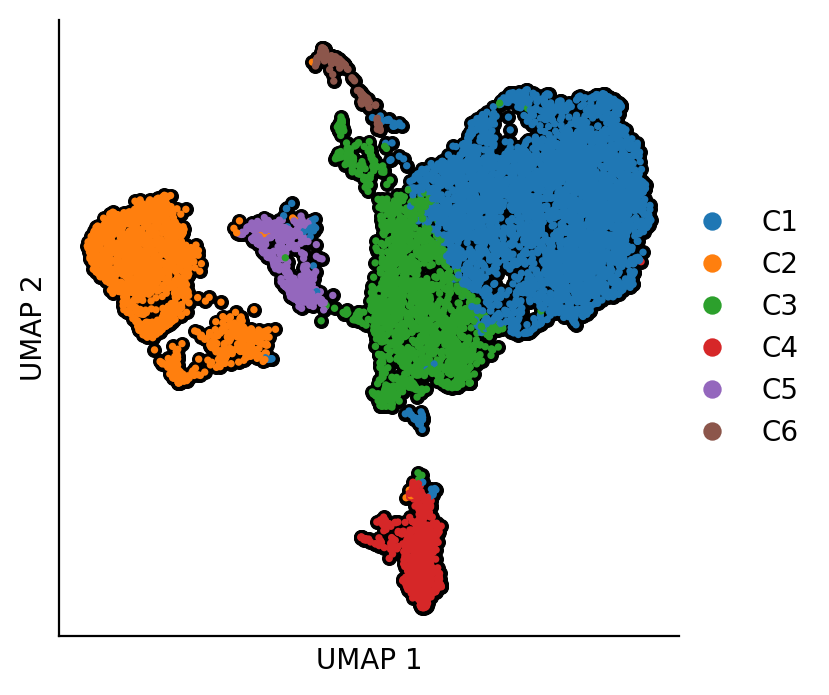

In [3]:
def plot_clusters(adata=adata, ax=None, legend=True):
    
    if ax is None:
        fig, ax = plt.subplots()
        
    sns.scatterplot(
        data=adata.obs,
        x='UMAP 1',
        y='UMAP 2',
        ec='k',
        color='k',
        s=25,
        zorder=1,
        ax=ax,
    )

    sns.scatterplot(
        data=adata.obs,
        x='UMAP 1',
        y='UMAP 2',
        ec='none',
        hue='cluster_str',
        s=7,
        # palette=colors,
        hue_order=sorted(adata.obs['cluster_str'].unique()),
        legend=legend,
        zorder=3,
        ax=ax,
    )
    plt.axis('auto')
    
    if legend:
        sns.move_legend(
            ax,
            title='',
            loc='center',
            markerscale=2.5,
            ncol=1,
            frameon=False,
            bbox_to_anchor=(1.1, 0.5),
        )
    ax.set_yticks([])
    ax.set_xticks([])
    sns.despine()
    
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
plot_clusters()

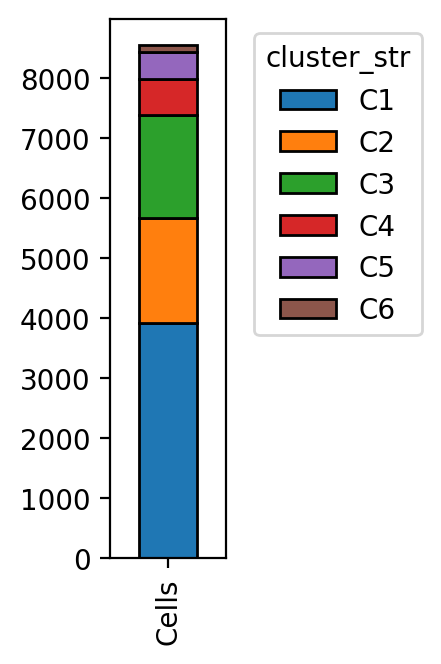

In [4]:

value_counts = adata.obs['cluster_str'].value_counts()
value_counts = value_counts.rename('Cells')
value_counts = pd.DataFrame(value_counts).T

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 0.75, 3.5

value_counts.plot(
    kind='bar', 
    stacked=True,
    ec='k',
)
sns.move_legend(
    plt.gca(), 
    loc='upper right',
    bbox_to_anchor=(2.8, 1),
)


In [5]:
def plot_gene_expression(exp_df, pdf, gene, cmap='viridis', ax=None, colorbar=True):
    """
    Plots gene expression on UMAP coordinates with color gradient.

    Args:
        exp_df: DataFrame containing gene expression data.
        pdf: DataFrame containing UMAP coordinates.
        gene: The gene to plot.
    """

    vector = exp_df[gene].values
    sorted_idx = np.argsort(vector)
    vmax = vector.max()
    vmin = vector.min()
    
    if ax is None:
        fig, ax = plt.subplots()

    # Base scatterplot (black dots)
    sns.scatterplot(
        data=pdf,
        x='UMAP 1',
        y='UMAP 2',
        ec='k',
        color='k',
        s=25,
        zorder=1,
        ax=ax,
    )

    # Expression-colored scatterplot
    sns.scatterplot(
        data=pdf.iloc[sorted_idx],
        x='UMAP 1',
        y='UMAP 2',
        ec='none',
        hue=vector[sorted_idx],
        palette=cmap,
        s=8,
        zorder=1,
        legend=False,
        ax=ax,
    )

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(gene)
    sns.despine(left=True, bottom=True)


    if colorbar:
        # Create colorbar
        norm = plt.Normalize(vmin, vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # This is necessary for the colorbar to work

        # Add colorbar to the plot
        cbar = ax.figure.colorbar(sm, ax=ax, shrink=0.45)
    
    plt.axis('auto')

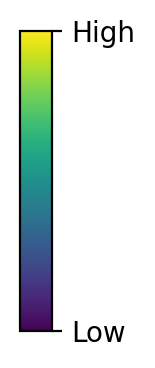

In [6]:
plt2.make_colorbar(tick_labels=['Low', 'High'])

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

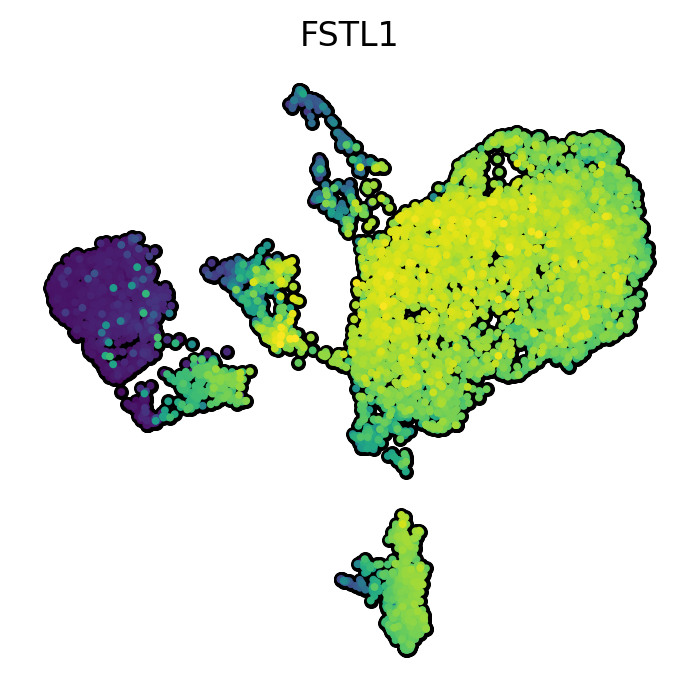

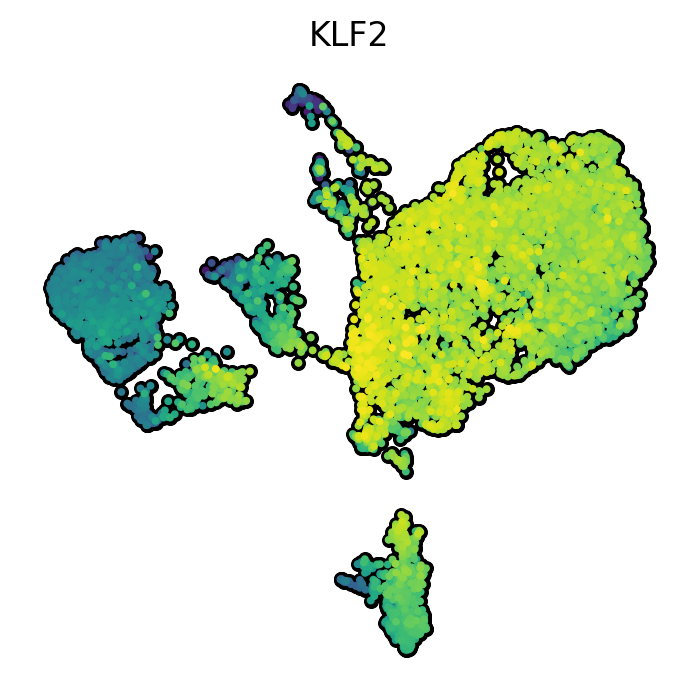

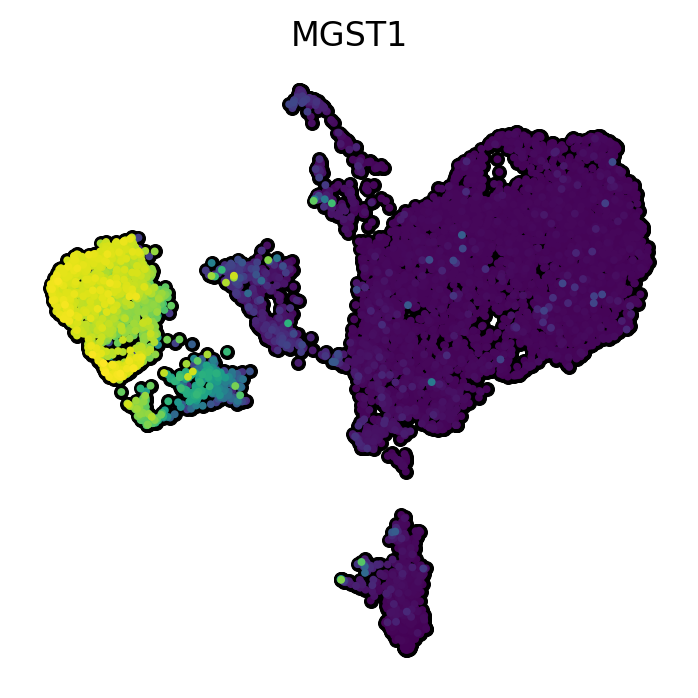

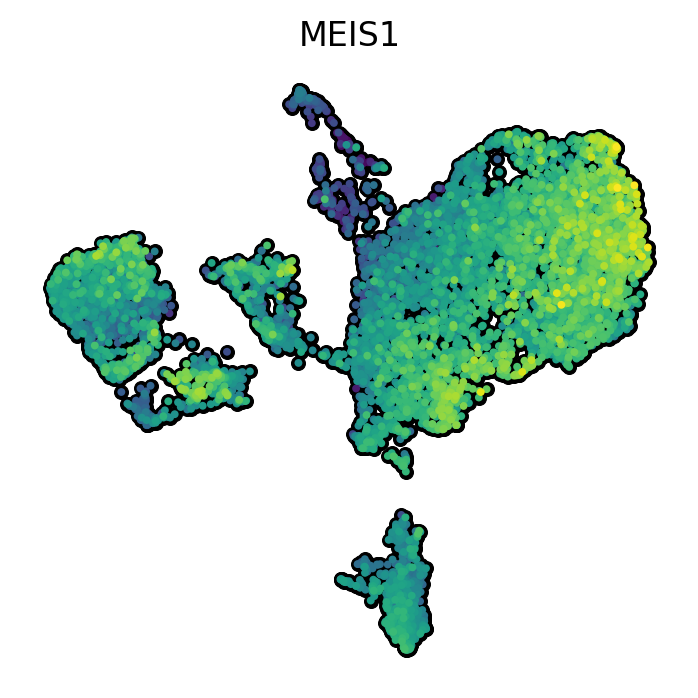

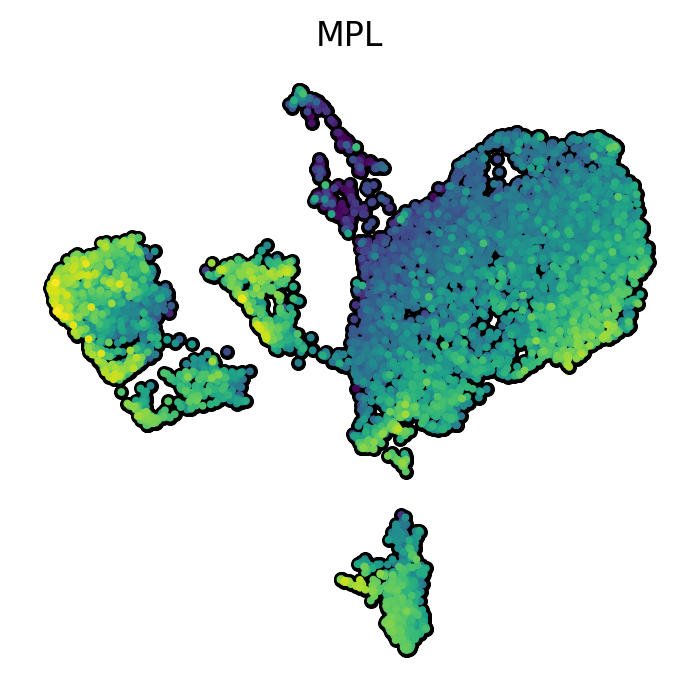

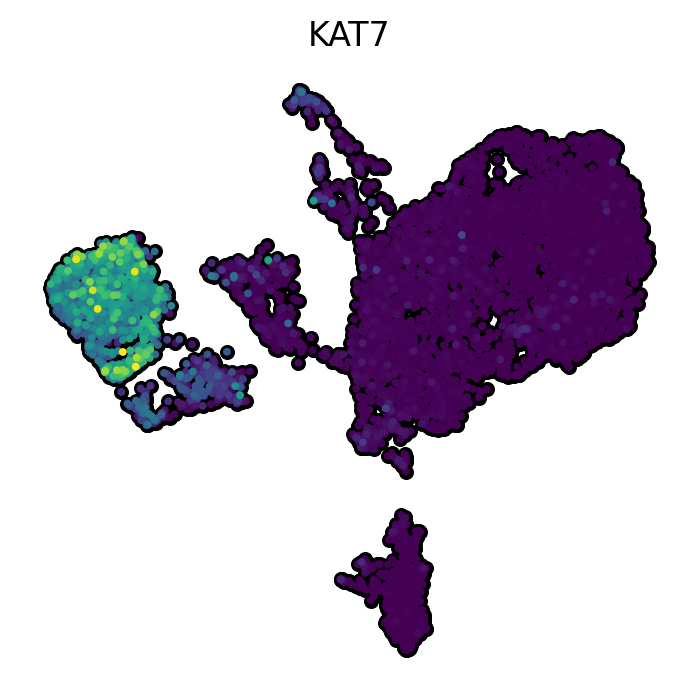

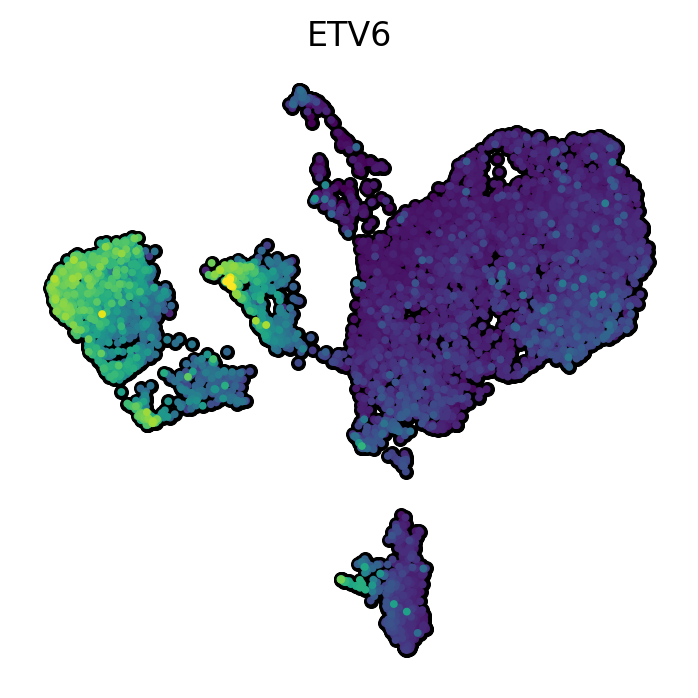

In [15]:
gene_list = [
    # 'CD34',
    # 'CD164',
    # 'GATA2',
    # 'STAT5A',
    # 'REL',
    # 'FOS',
    # 'GFI1B',
    'FSTL1',
    'KLF2',
    'MGST1',
    'MEIS1',
    'MPL',
    'KAT7',
    'ETV6',
    # 'MGST1',
    # 'MGP',
]

layer = 'magic'

pdf = adata.obs.copy()
exp_df = adata[:, gene_list].to_df(layer=layer)

for gene in gene_list:
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 4.25, 4
    plot_gene_expression(exp_df, pdf, gene, cmap='viridis', colorbar=False)
    # break

# stacked bars

In [16]:
adata

AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'magic', 'raw_counts'
    obsp: 'connectivities', 'dista

In [79]:
fpath = "../resources/Tabula_Sapiens.txt"
pdf = ut.load_pathway(fpath)  

columns = [
    'Blood-hematopoietic Stem Cell',
    'Bone Marrow-hematopoietic Stem Cell',
    'Lymph Node-hematopoietic Stem Cell',
    'Spleen-hematopoietic Stem Cell',
    'Bladder-fibroblast',
    'Bladder-myofibroblast Cell',
    'Lung-alveolar Fibroblast',
    'Large Intestine-fibroblast',
    'Lung-fibroblast',
    'Small Intestine-fibroblast',
    'Thymus-fibroblast',
    'Vasculature-fibroblast',
    'Mammary-fibroblast Of Breast',
    'Uterus-fibroblast',
    'Eye-fibroblast',
    'Liver-fibroblast',
    'Trachea-fibroblast',
    'Salivary Gland-fibroblast',
    'Tongue-fibroblast',
    'Prostate-fibroblast',
    'Pancreas-fibroblast',
    'Fat-fibroblast',
    'Heart-fibroblast Of Cardiac Tissue',
]

pdf = pdf[columns]
pdf = pdf[pdf.index.isin(adata.var_names)]
print(f"{pdf.shape=}")

pdf.head()

pdf.shape=(1191, 23)


label,Blood-hematopoietic Stem Cell,Bone Marrow-hematopoietic Stem Cell,Lymph Node-hematopoietic Stem Cell,Spleen-hematopoietic Stem Cell,Bladder-fibroblast,Bladder-myofibroblast Cell,Lung-alveolar Fibroblast,Large Intestine-fibroblast,Lung-fibroblast,Small Intestine-fibroblast,...,Uterus-fibroblast,Eye-fibroblast,Liver-fibroblast,Trachea-fibroblast,Salivary Gland-fibroblast,Tongue-fibroblast,Prostate-fibroblast,Pancreas-fibroblast,Fat-fibroblast,Heart-fibroblast Of Cardiac Tissue
GDF15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
RPL21,True,True,True,True,True,True,True,True,False,True,...,True,False,True,True,True,True,True,False,True,True
RPS9,True,True,True,True,True,True,True,True,True,True,...,True,False,False,False,True,True,True,False,True,True
RPS7,True,True,True,True,False,True,True,False,True,True,...,True,False,True,False,False,False,False,False,False,False
SPINK1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [103]:
result = []

layer = 'magic'
group = 'cluster_str'

exp_df = adata.to_df(layer=layer).replace(0.0, pd.NA)
exp_df['group'] = adata.obs[group].values

for column in pdf.columns:
    gene_list = list(pdf[pdf[column]].index)
    print(f"{column} {len(gene_list)}")
    
    row = exp_df.groupby('group')[gene_list].mean().mean(axis=1)
    row = row.to_dict()
    row['marker'] = column
    
    result.append(row)

    
result = pd.DataFrame(result)
print(f"{result.shape=}")
result = result.set_index("marker")
result

/tmp/ipykernel_1884104/3883012584.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  exp_df['group'] = adata.obs[group].values


Blood-hematopoietic Stem Cell 69
Bone Marrow-hematopoietic Stem Cell 71
Lymph Node-hematopoietic Stem Cell 74
Spleen-hematopoietic Stem Cell 73
Bladder-fibroblast 66
Bladder-myofibroblast Cell 68
Lung-alveolar Fibroblast 67
Large Intestine-fibroblast 69
Lung-fibroblast 74
Small Intestine-fibroblast 69
Thymus-fibroblast 67
Vasculature-fibroblast 69
Mammary-fibroblast Of Breast 70
Uterus-fibroblast 68
Eye-fibroblast 73
Liver-fibroblast 68
Trachea-fibroblast 69
Salivary Gland-fibroblast 67
Tongue-fibroblast 67
Prostate-fibroblast 68
Pancreas-fibroblast 68
Fat-fibroblast 70
Heart-fibroblast Of Cardiac Tissue 65
result.shape=(23, 7)


,C1,C2,C3,C4,C5,C6
marker,,,,,,
Blood-hematopoietic Stem Cell,0.168152,0.168721,0.153998,0.189827,0.168377,0.061202
Bone Marrow-hematopoietic Stem Cell,0.167189,0.168854,0.153870,0.190546,0.168875,0.059440
Lymph Node-hematopoietic Stem Cell,0.167689,0.169963,0.149694,0.191129,0.178659,0.064295
Spleen-hematopoietic Stem Cell,0.251308,0.242678,0.233717,0.272006,0.252577,0.099666
Bladder-fibroblast,0.136289,0.145248,0.122229,0.158351,0.143953,0.052920
Bladder-myofibroblast Cell,0.163226,0.162811,0.149605,0.185847,0.166523,0.069626
Lung-alveolar Fibroblast,0.118816,0.122404,0.103842,0.140495,0.122985,0.046331
Large Intestine-fibroblast,0.176119,0.174914,0.159871,0.198174,0.180610,0.075513
Lung-fibroblast,0.179813,0.181847,0.167718,0.202970,0.180660,0.102261


<Axes: ylabel='marker'>

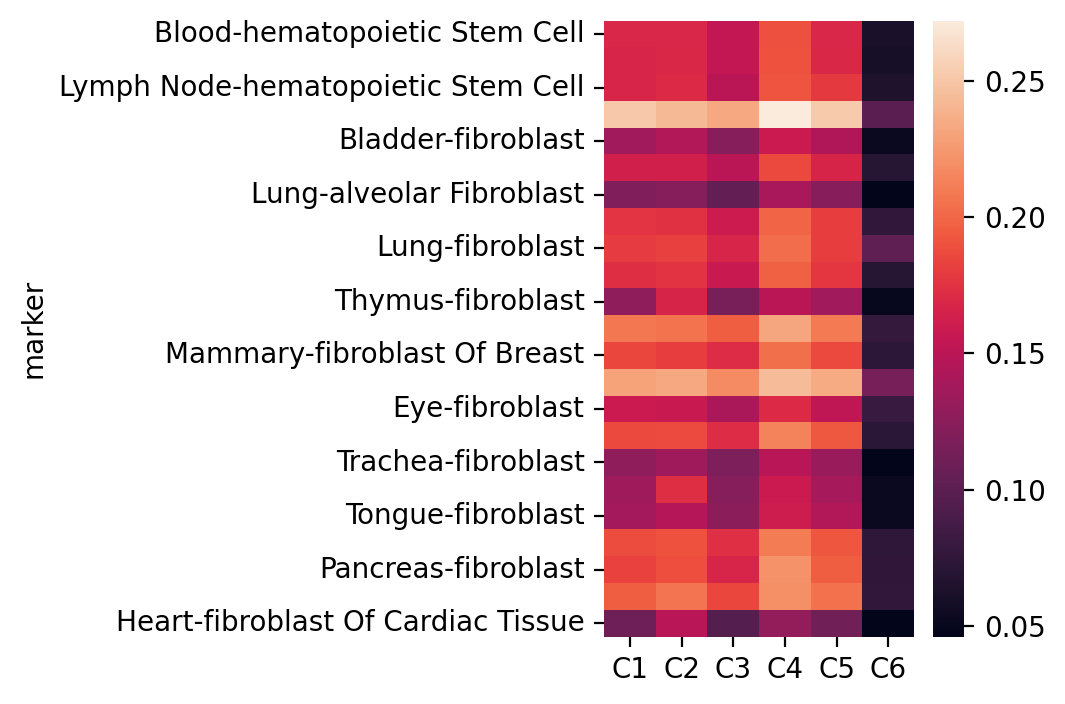

In [104]:
sns.heatmap(result)

In [72]:
gene_list = [
    'BRCA2', 
    'CD34', 
    'FOS', 
    'ERG',  
]

layer = 'raw_counts'
group = 'cluster_str'

pdf = adata.obs.copy()
exp_df = adata[:, gene_list].to_df(layer=layer).astype(bool)
exp_df[group] = pdf[group].values


# exp_df = exp_df.groupby(group).sum()
# exp_df = exp_df.divide(exp_df.sum(axis=0), axis=1) * 100

exp_df

,BRCA2,CD34,FOS,ERG,cluster_str
cell_id,,,,,
AAACCCAAGGTTACCT,False,True,False,False,C1
AAACCCAAGTTGAAGT,False,False,False,False,C1
AAACCCAAGTTGTCGT,False,False,False,False,C4
AAACCCACAGAAGCGT,False,True,False,False,C2
AAACCCACAGGAGGTT,False,True,False,False,C1
...,...,...,...,...,...
TTTGTTGCAAGAGGTC,False,False,False,False,C1
TTTGTTGCATGTGGTT,False,False,True,False,C5
TTTGTTGGTATACCCA,False,False,False,False,C1


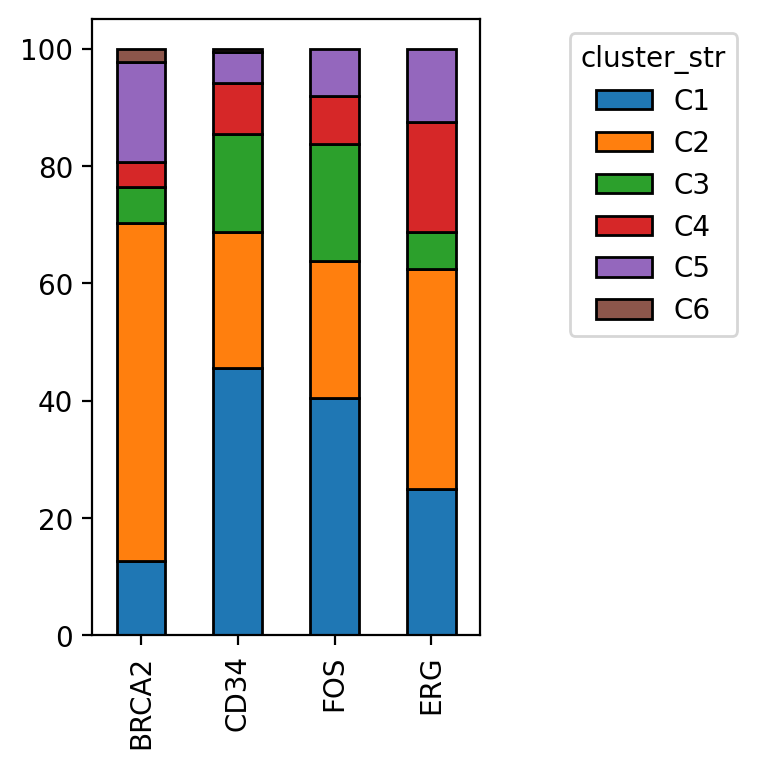

In [71]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2.5, 4

exp_df.T.plot(
    kind='bar', 
    stacked=True,
    ec='k',
)
sns.move_legend(
    plt.gca(), 
    loc='upper right',
    bbox_to_anchor=(1.7, 1),
)


In [30]:
1752 * 0.055

96.36

In [23]:
pdf[group].value_counts()

cluster_str
C1    3927
C2    1752
C3    1708
C4     602
C5     447
C6     127
Name: count, dtype: int64

In [ ]:
break